In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import folium

In [2]:
train = pd.read_csv("train.csv")
shoppingmalls = pd.read_csv("auxiliary-data/sg-shopping-malls.csv")

In [3]:
len(shoppingmalls), len(shoppingmalls["name"].unique())

(163, 162)

In [4]:
shoppingmalls = shoppingmalls.drop_duplicates()

In [5]:
train["shops_in_3km"] = train["longitude"]
train["nearest_shop_name"] = train["longitude"]
train["nearest_shop_distance"] = train["longitude"]
from geopy.distance import geodesic
for index in tqdm(train.index):
    latitude, longitude = train.loc[index, "latitude"], train.loc[index, "longitude"]
    nearest_shop_dis = 1000000000
    nearest_shop_name = "None"
    shops_3km = 0
    for ind in shoppingmalls.index:
        lat2, long2 = shoppingmalls.loc[ind, "latitude"], shoppingmalls.loc[ind, "longitude"]
        # Spherical distance between two locations, using the longitude and the latitude to calculate.
        distance = geodesic((latitude, longitude), (lat2, long2)).kilometers
        if distance < 3:
            shops_3km += 1
        if nearest_shop_dis > distance:
            nearest_shop_dis = distance
            nearest_shop_name = shoppingmalls.loc[ind, "name"]
    train.loc[index, "shops_in_3km"] = shops_3km
    train.loc[index, "nearest_shop_distance"] = distance
    train.loc[index, "nearest_shop_name"] = nearest_shop_name


100%|████████████████████████████████████████████████████████████████████████████| 60000/60000 [29:52<00:00, 33.46it/s]


In [6]:
train.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,shops_in_3km,nearest_shop_name,nearest_shop_distance
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600,7.0,Westgate,9.567144
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250,9.0,Djitsun Mall Bedok,15.778858
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900,12.0,HDB Hub,6.816051
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850,6.0,Loyang Point,19.964025
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100,22.0,Aperia,7.598396


In [7]:
train.to_csv("train_with_shops.csv",index=False)

In [8]:
shops_info_slice = train[["shops_in_3km", "nearest_shop_distance", "nearest_shop_name", "monthly_rent"]]
shops_info_slice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   shops_in_3km           60000 non-null  float64
 1   nearest_shop_distance  60000 non-null  float64
 2   nearest_shop_name      60000 non-null  object 
 3   monthly_rent           60000 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 1.8+ MB


In [9]:
correlation = shops_info_slice["shops_in_3km"].corr(shops_info_slice['monthly_rent'])
correlation

0.12593483444323167

In [10]:
correlation = shops_info_slice["nearest_shop_distance"].corr(shops_info_slice['monthly_rent'])
correlation

-0.10064183050553295

In [11]:
group_nearest_shop = shops_info_slice.groupby("nearest_shop_name").mean()
group_nearest_shop, group_nearest_shop.index

(                               shops_in_3km  nearest_shop_distance  \
 nearest_shop_name                                                    
 100 AM                            28.698529               4.363220   
 321 Clementi                       9.907853               5.271955   
 888 Plaza                          8.834225              16.495464   
 AMK Hub                            3.160000              11.280105   
 Admiralty Place                   10.113530              16.940460   
 ...                                     ...                    ...   
 Yew Tee Point                     10.181347              13.493974   
 Yew Tee Square                     8.794872              14.013798   
 Zhongshan Mall                    21.770677               6.812795   
 i12 Katong                        12.000000              12.451074   
 myVillage At Serangoon Garden     10.694444              11.023220   
 
                                monthly_rent  
 nearest_shop_name          

In [12]:
shops_loc_rent = group_nearest_shop.merge(shoppingmalls, left_on=group_nearest_shop.index, right_on="name")
shops_loc_rent

,shops_in_3km,nearest_shop_distance,monthly_rent,name,latitude,longitude
0,28.698529,4.363220,3827.389706,100 AM,1.274588,103.843471
1,9.907853,5.271955,2667.015707,321 Clementi,1.316550,103.766331
2,8.834225,16.495464,2504.679144,888 Plaza,1.437119,103.795316
3,3.160000,11.280105,2538.000000,AMK Hub,1.389906,103.847738
4,10.113530,16.940460,2571.695179,Admiralty Place,1.440420,103.801542
...,...,...,...,...,...,...
109,10.181347,13.493974,2572.020725,Yew Tee Point,1.397084,103.746598
110,8.794872,14.013798,2486.217949,Yew Tee Square,1.398047,103.747085
111,21.770677,6.812795,2326.691729,Zhongshan Mall,1.326945,103.846554
112,12.000000,12.451074,2260.156250,i12 Katong,1.305223,103.905044


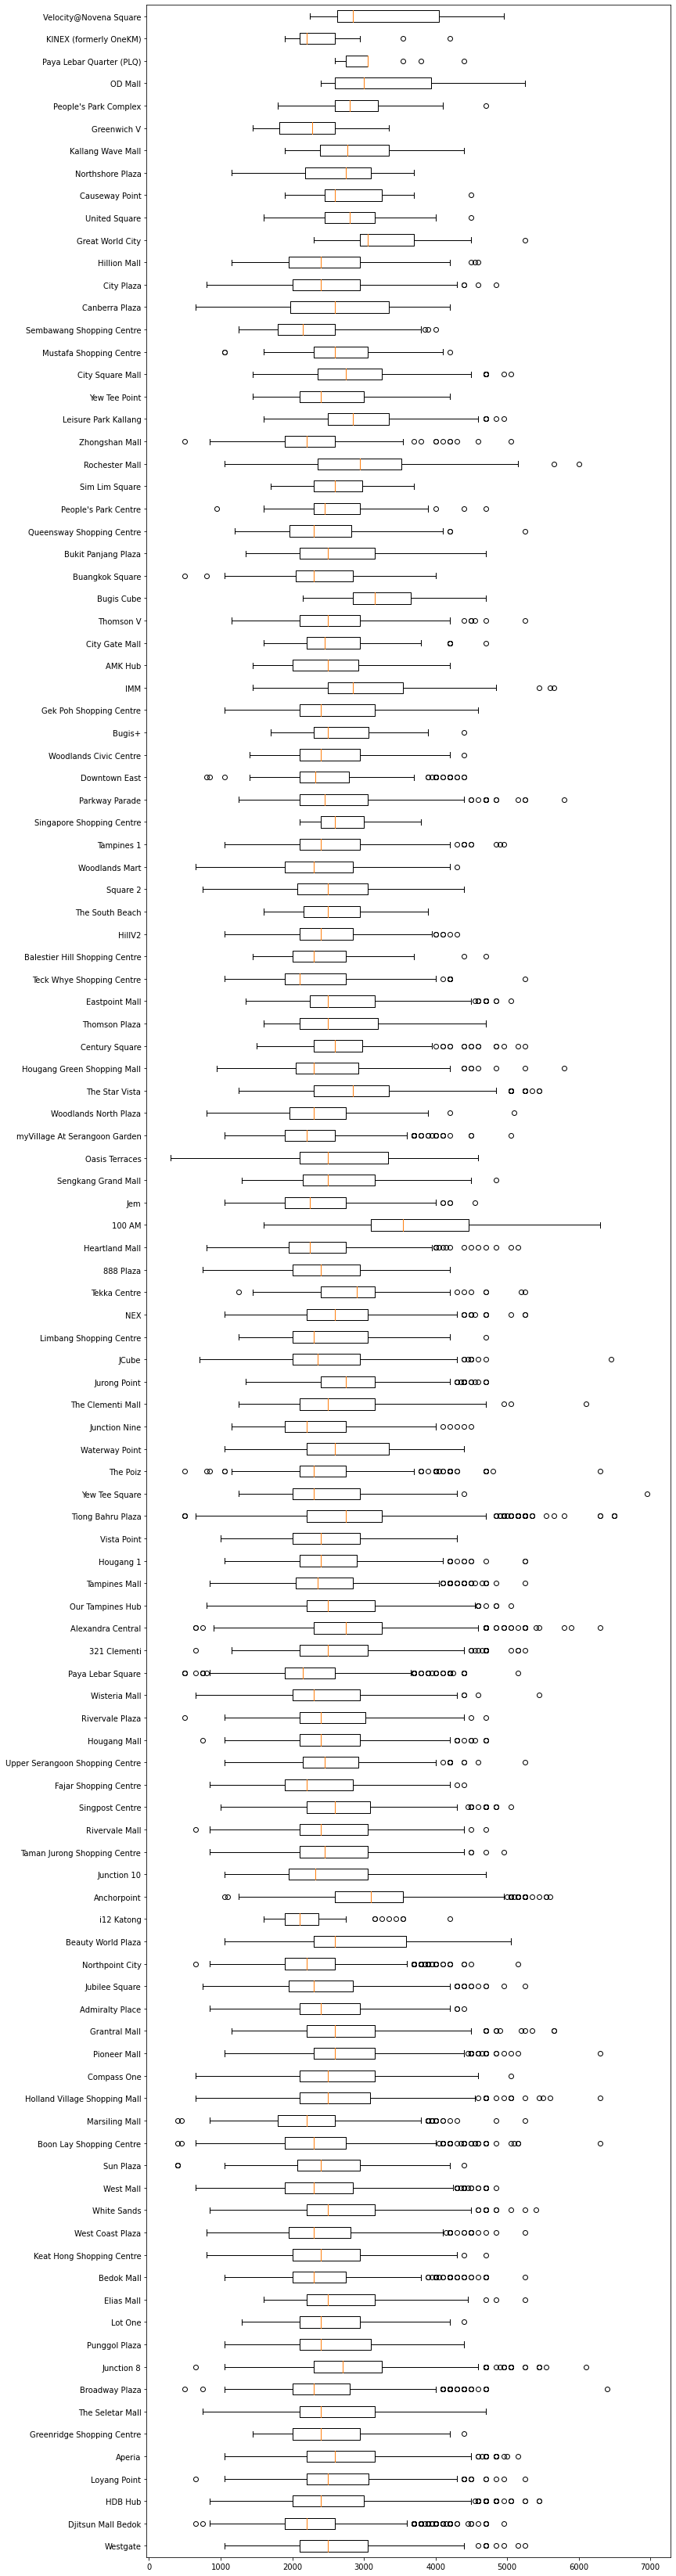

In [13]:
plt.figure(figsize=(12, 60))
ss = shops_info_slice["nearest_shop_name"].unique()
boxplot_data = []
for s in ss:
    boxplot_data.append(shops_info_slice[shops_info_slice["nearest_shop_name"] == s]["monthly_rent"])

plt.boxplot(boxplot_data, labels=ss, vert=False)
plt.show()